# Prediction of drug target interaction for drug discovery

### Introduction

This notebook aims to provide a response for the challenge, by proposing a simple pipeline based on ECFP (Morgan) fingerprints combined with a Random Forest algorithm. The objective is to predict the pIC50 of various drugs on a protein. 


### Imports

You can uncomment and run the cell below to install the latest version of the RDKit package.

In [1]:
# Linear algebra and data handling
import numpy as np
import pandas as pd

# RDKit
import rdkit 
from rdkit import Chem
from rdkit.Chem import AllChem, Draw


# Machine learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, median_absolute_error

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

### Data loading and preprocessing

In [ ]:
X_train = pd.read_csv('/Users/claire/Desktop/ENSAE/3A/projet_advanced_ML/aml_project/notebooks/final_train.csv')
X_test = pd.read_csv('/Users/claire/Desktop/ENSAE/3A/projet_advanced_ML/aml_project/notebooks/final_test.csv')

### Machine learning

Cross-validation is a good practice to estimate the "true" performance of a model on unseen data. If the cross-validation scores are satisfying, we can then train the model on the entire dataset and predict the test set. For this introduction we use the default parameters of the Random Forest, but keep in mind they might need to be optimized for the challenge. You are encouraged to try other models.

This run can take a few minutes depending on your computer. 

In [38]:
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import warnings 
warnings.filterwarnings('ignore')

Create train and test set

In [71]:
xtrain,xtest,ytrain,ytest=train_test_split(X_train,y_train, random_state=42, test_size=.30)

In [40]:
xtrain

,num_of_atoms,num_of_heavy_atoms,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,feature_2039,feature_2040,feature_2041,feature_2042,feature_2043,feature_2044,feature_2045,feature_2046,feature_2047,feature_2048
1829,45,32,15.488951,15.488951,0.392157,-3.133384,0.197292,16.562500,559.238,546.134,...,0,0,0,0,0,0,0,0,0,0
2274,45,28,8.783031,8.783031,0.059623,-1.134091,0.348500,21.035714,384.870,367.734,...,0,0,0,0,0,0,0,0,0,0
218,52,30,13.505416,13.505416,0.157943,-3.743868,0.541190,29.133333,398.470,376.294,...,0,0,0,0,0,0,0,0,0,0
3793,60,37,14.575850,14.575850,0.293839,-5.794684,0.308152,21.540541,508.504,485.320,...,0,0,0,0,0,0,0,0,0,0
1770,61,36,13.556725,13.556725,0.022753,-3.452792,0.312727,22.277778,483.528,458.328,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,67,35,14.765219,14.765219,0.513060,-5.250268,0.639221,86.428571,472.589,440.333,...,0,0,0,0,0,0,0,0,0,0
466,48,32,13.001518,13.001518,0.236551,-5.371670,0.379569,20.125000,439.401,423.273,...,0,0,0,0,0,0,0,0,0,0
3092,64,31,9.040185,9.040185,0.043117,-4.807649,0.503878,41.483871,423.561,390.297,...,0,0,0,0,0,0,0,0,0,0
3772,36,24,12.963466,12.963466,0.050837,-3.092018,0.537427,20.208333,357.826,345.730,...,0,0,0,0,0,0,0,0,0,0


try to see differences in x where y is near of 5 (pic of values)

In [41]:
diff=pd.DataFrame(xtrain.mean()-xtrain[(ytrain>4.8)&(ytrain<5.01)].mean())
print(diff.max())
diff

0    1.409551e+20
dtype: float64


,0
num_of_atoms,4.165514
num_of_heavy_atoms,2.122370
MaxAbsEStateIndex,0.359428
MaxEStateIndex,0.359428
MinAbsEStateIndex,0.019183
...,...
feature_2044,0.015533
feature_2045,0.007143
feature_2046,-0.004324
feature_2047,0.002870


array([[<Axes: title={'center': '0'}>]], dtype=object)

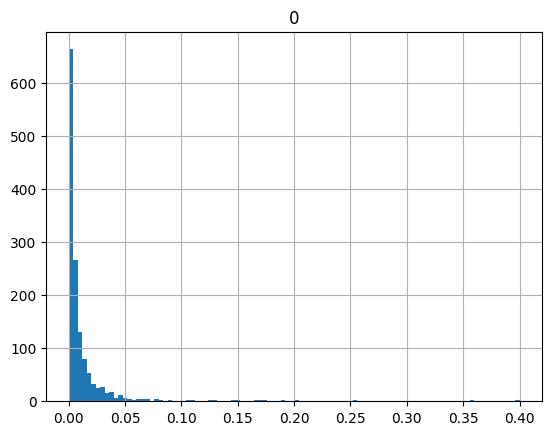

In [45]:
diff.hist(range=(0,0.4),bins=100)

Rnadom Forest : hyper parameters

In [76]:
rf_params = {
    'n_estimators': [100, 200],   #, 200, 300], #https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html
    'criterion': ['absolute_error'], #'squared_error', 'absolute_error', 
    'max_depth': [None, 20],   #, 20, 30],
    'min_samples_split': [2, 10],   #, 10],
    'min_samples_leaf': [1, 4]   #, 4],
    #'max_features': ['auto', 'sqrt', 'log2']
}

rf_params_2 = {
    'n_estimators': [200, 300], 
    'max_depth': [None],
    'min_samples_split': [2, 10],  
    'min_samples_leaf': [1, 4] ,
    'n_jobs': [-1]
}

# attribution du meme poids que les valeurs proches de 6 aux valeurs prepondérantes proches de 5
weights = np.where((ytrain>4.9999)&(ytrain<5.0001), np.sum((ytrain>5.9999)&(ytrain<6.0001))/len(ytrain), 1.0)

Hyper parametrization : Grid search

In [65]:
# Perform Grid Search for Random Forest
rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1),
                              param_grid=rf_params, cv=5)
rf_grid_search.fit(xtrain, ytrain)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'criterion': ['absolute_error'],
                         'max_depth': [None, 20], 'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 200]})

In [77]:
# Perform Grid Search for Random Forest
rf_grid_search_2 = GridSearchCV(estimator=RandomForestRegressor(),
                              param_grid=rf_params_2, cv=5)
rf_grid_search_2.fit(xtrain[:1000], ytrain[:1000])

KeyboardInterrupt: 

In [ ]:
tuning_result_rf_gs = pd.DataFrame(rf_grid_search.cv_results_)
tuning_result_rf_gs

In [68]:
rf_grid_search.best_params_

{'criterion': 'absolute_error',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [118]:
rf_grid_search_2.best_params_

{'criterion': 'absolute_error', 'max_depth': None, 'n_estimators': 200}

In [80]:
# Random Forest Grid Search 1
y_pred_rf_gs = rf_grid_search.predict(xtest)
print("\nRandom Forest Grid Search Performance:")
print("mae:", mean_absolute_error(ytest, y_pred_rf_gs))


Random Forest Grid Search Performance:
mae: 0.74446507121058


In [91]:
# Random Forest Grid Search 2
y_pred_rf_gs = rf_grid_search_2.predict(xtest)
print("\nRandom Forest Grid Search Performance:")
print("mae:", mean_absolute_error(ytest, y_pred_rf_gs))


Random Forest Grid Search Performance:
mae: 0.6016572892093783


In [139]:
model = RandomForestRegressor(max_depth=None,n_estimators= 100,n_jobs=-1)

cv = cross_validate(estimator=model, 
                    X=xtrain, 
                    y=ytrain,
                    cv=5, 
                    scoring=["neg_median_absolute_error", "neg_root_mean_squared_error"],
                    n_jobs=-1,
                    verbose=0)

print(f"Mean MAE over 10 folds = {-cv['test_neg_median_absolute_error'].mean():.4f}")
print(f"Mean RMSE over 10 folds = {-cv['test_neg_root_mean_squared_error'].mean():.4f}")

Mean MAE over 10 folds = 0.4530
Mean RMSE over 10 folds = 0.7880


In [85]:
model = RandomForestRegressor(max_depth=None,n_estimators= 100,n_jobs=-1)
model.fit(xtrain,ytrain)
ypred = model.predict(xtest)
print("mae:", median_absolute_error(ytest, ypred))


mae: 0.4957893012814609


In [74]:
print("mae:", mean_absolute_error(ytest, ypred))

mae: 0.6415638599400488


In [81]:
np.argsort(model.feature_importances_)[::-1]

array([ 535,  187,  191, ..., 1454,    6, 1015])

Hyper parametrization : Random Search

In [22]:
rf_random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                      param_distributions=rf_params_2, n_iter=100, cv=5, random_state=42)
rf_random_search.fit(xtrain, ytrain)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None],
                                        'n_estimators': [200, 250]},
                   random_state=42)

In [23]:
rf_random_search.best_params_

{'n_estimators': 200, 'max_depth': None}

In [24]:
# Random Forest Random Search 
y_pred_rf_rs = rf_random_search.predict(xtest)
print("\nRandom Forest Grid Search Performance:")
print("mae:", mean_absolute_error(ytest, y_pred_rf_rs))


Random Forest Grid Search Performance:
mae: 0.6002539812834865


In [25]:
mae_linear = mean_absolute_error(ytest, y_pred_rf_rs)
print(f"Mean Absolute Error (Linear Regression): {mae_linear:.4f}")

Mean Absolute Error (Linear Regression): 0.6003


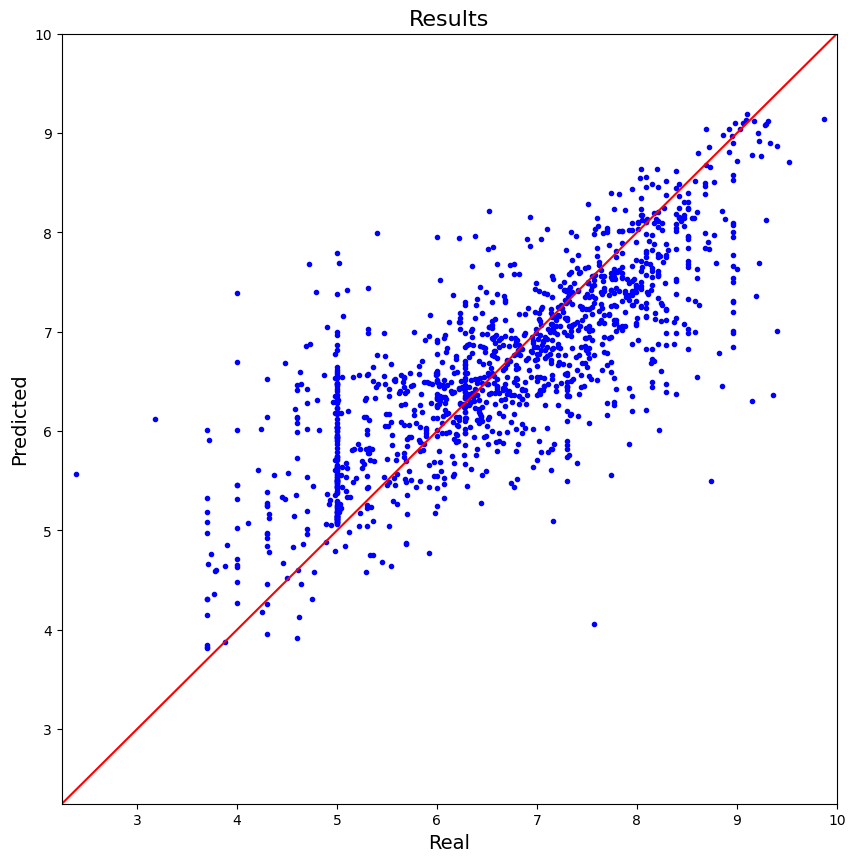

In [35]:
plt.figure(figsize=(10,10))
x=np.linspace(0,10,10)
plt.plot(ytest, y_pred_rf_rs, 'b.')
plt.plot(x, x, 'r-')
plt.xlim(2.25,10)
plt.ylim(2.25,10)
plt.title("Results", fontsize=16)
plt.xlabel("Real", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.savefig("Results.png")
plt.show()

Test autres modeles classiques pour regression

In [39]:
from sklearn.linear_model import LinearRegression,Ridge, Lasso, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

Regression linéaire

In [28]:
# Régression Linéaire
linear_model = LinearRegression()
linear_model.fit(xtrain, ytrain)

# Prédictions sur l'ensemble de test
y_pred_linear = linear_model.predict(xtest)

# Calcul de la Mean Absolute Error (MAE) pour la régression linéaire
mae_linear = mean_absolute_error(ytest, y_pred_linear)
print(f"Mean Absolute Error (Linear Regression): {mae_linear:.4f}")

Mean Absolute Error (Linear Regression): 107424474.3715


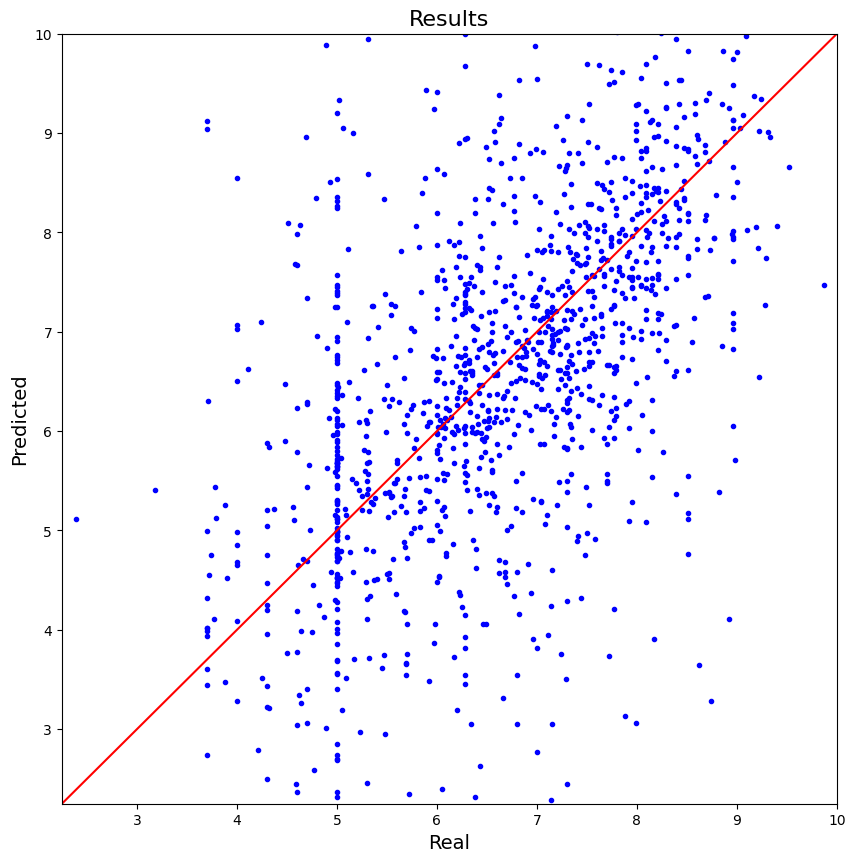

In [34]:
plt.figure(figsize=(10,10))
x=np.linspace(0,10,10)
plt.plot(ytest, y_pred_linear, 'b.')
plt.plot(x, x, 'r-')
plt.xlim(2.25,10)
plt.ylim(2.25,10)
plt.title("Results", fontsize=16)
plt.xlabel("Real", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.savefig("Results.png")
plt.show()

Gradient Boosting

In [36]:
# Gradient Boosting Regressor
gradient_boosting_model = GradientBoostingRegressor()
gradient_boosting_model.fit(xtrain, ytrain)

# Prédictions sur l'ensemble de test
y_pred_gb = gradient_boosting_model.predict(xtest)

# Calcul de la Mean Absolute Error (MAE) pour le Gradient Boosting Regressor
mae_gb = mean_absolute_error(ytest, y_pred_gb)
print(f"Mean Absolute Error (Gradient Boosting): {mae_gb:.4f}")

Mean Absolute Error (Gradient Boosting): 0.7652


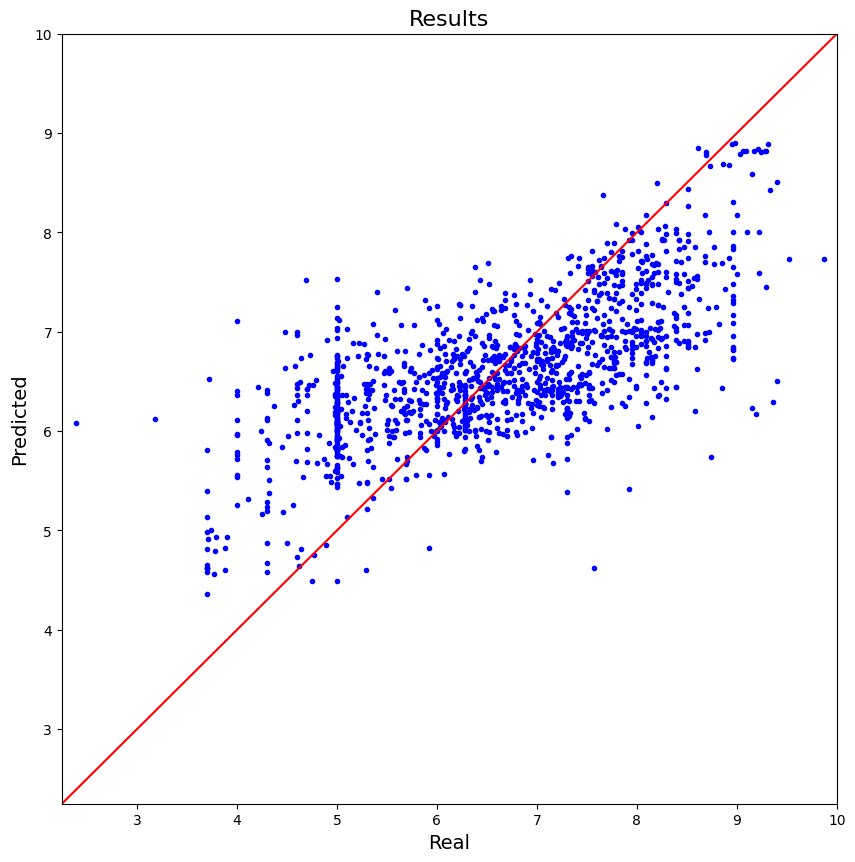

In [37]:
plt.figure(figsize=(10,10))
x=np.linspace(0,10,10)
plt.plot(ytest, y_pred_gb, 'b.')
plt.plot(x, x, 'r-')
plt.xlim(2.25,10)
plt.ylim(2.25,10)
plt.title("Results", fontsize=16)
plt.xlabel("Real", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.savefig("Results.png")
plt.show()

avec poids

In [93]:



# Gradient Boosting Regressor avec poids
gb_model_weighted = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model_weighted.fit(xtrain, ytrain, sample_weight=weights)

# Prédictions sur l'ensemble de test
y_pred_weighted = gb_model_weighted.predict(xtest)

# Calcul de la Mean Absolute Error (MAE) avec poids
mae_weighted = mean_absolute_error(ytest, y_pred_weighted)
print(f"Mean Absolute Error (Gradient Boosting with Weights): {mae_weighted:.4f}")

Mean Absolute Error (Gradient Boosting with Weights): 0.7906


Support Vector Regressor

In [40]:
# Support Vector Regressor (SVR)
svr_model = SVR()
svr_model.fit(xtrain, ytrain)

# Prédictions sur l'ensemble de test
y_pred_svr = svr_model.predict(xtest)

# Calcul de la Mean Absolute Error (MAE) pour le SVR
mae_svr = mean_absolute_error(ytest, y_pred_svr)
print(f"Mean Absolute Error (SVR): {mae_svr:.4f}")

Mean Absolute Error (SVR): 0.9180


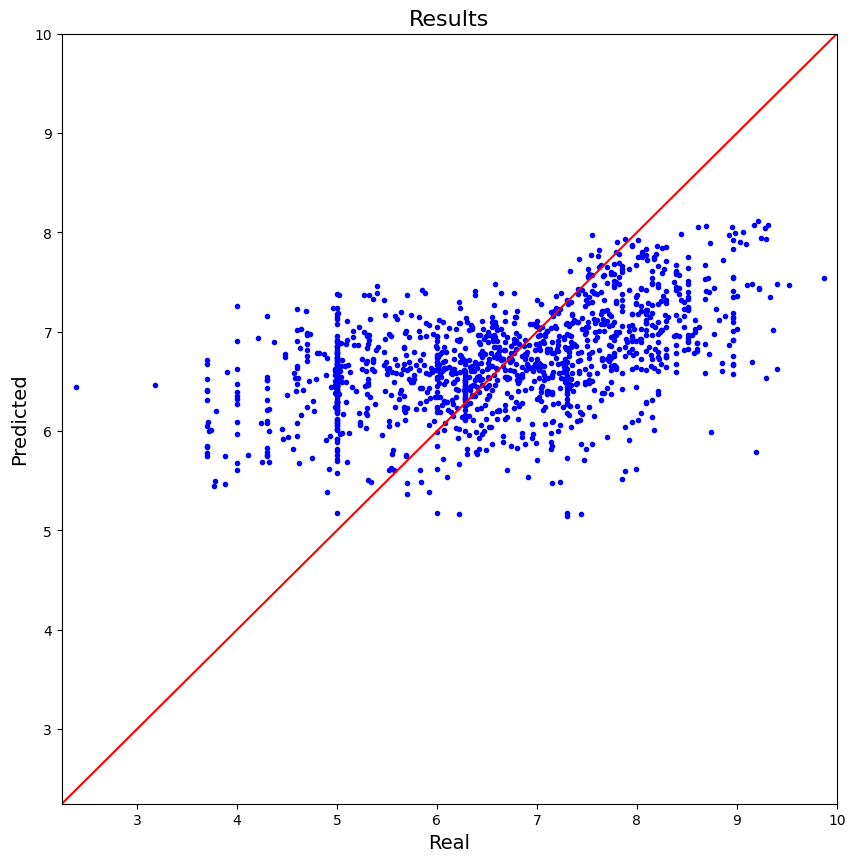

In [41]:
plt.figure(figsize=(10,10))
x=np.linspace(0,10,10)
plt.plot(ytest, y_pred_svr, 'b.')
plt.plot(x, x, 'r-')
plt.xlim(2.25,10)
plt.ylim(2.25,10)
plt.title("Results", fontsize=16)
plt.xlabel("Real", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.savefig("Results.png")
plt.show()

Régression Ridge ou Lasso

In [42]:
# Régression Ridge
ridge_model = Ridge()
ridge_model.fit(xtrain, ytrain)

# Prédictions sur l'ensemble de test
y_pred_ridge = ridge_model.predict(xtest)

# Calcul de la Mean Absolute Error (MAE) pour la Régression Ridge
mae_ridge = mean_absolute_error(ytest, y_pred_ridge)
print(f"Mean Absolute Error (Ridge): {mae_ridge:.4f}")

Mean Absolute Error (Ridge): 0.7255


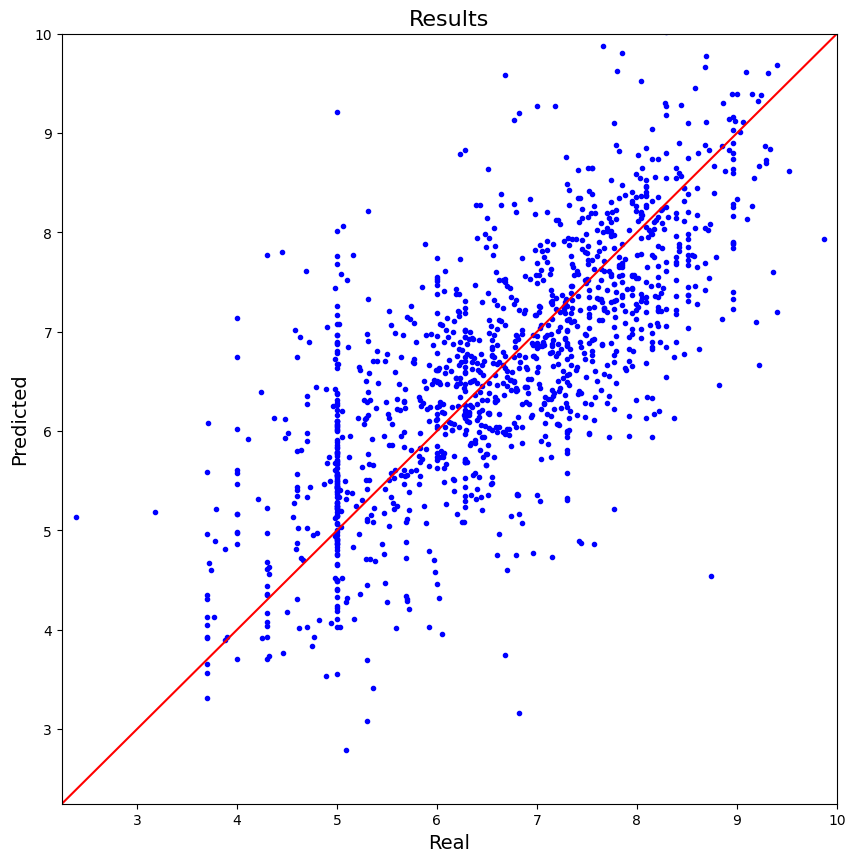

In [43]:
plt.figure(figsize=(10,10))
x=np.linspace(0,10,10)
plt.plot(ytest, y_pred_ridge, 'b.')
plt.plot(x, x, 'r-')
plt.xlim(2.25,10)
plt.ylim(2.25,10)
plt.title("Results", fontsize=16)
plt.xlabel("Real", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.savefig("Results.png")
plt.show()

In [45]:
# Régression Lasso
lasso_model = Lasso()
lasso_model.fit(xtrain, ytrain)

# Prédictions sur l'ensemble de test
y_pred_lasso = lasso_model.predict(xtest)

# Calcul de la Mean Absolute Error (MAE) pour la Régression Lasso
mae_lasso = mean_absolute_error(ytest, y_pred_lasso)
print(f"Mean Absolute Error (Lasso): {mae_lasso:.4f}")

Mean Absolute Error (Lasso): 1.0630


Régression Bayesian Ridge

In [47]:
# Régression Bayesian Ridge
bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(xtrain, ytrain)

# Prédictions sur l'ensemble de test
y_pred_bayesian_ridge = bayesian_ridge_model.predict(xtest)

# Calcul de la Mean Absolute Error (MAE) pour la Régression Bayesian Ridge
mae_bayesian_ridge = mean_absolute_error(ytest, y_pred_bayesian_ridge)
print(f"Mean Absolute Error (Bayesian Ridge): {mae_bayesian_ridge:.4f}")

Mean Absolute Error (Bayesian Ridge): 0.6693


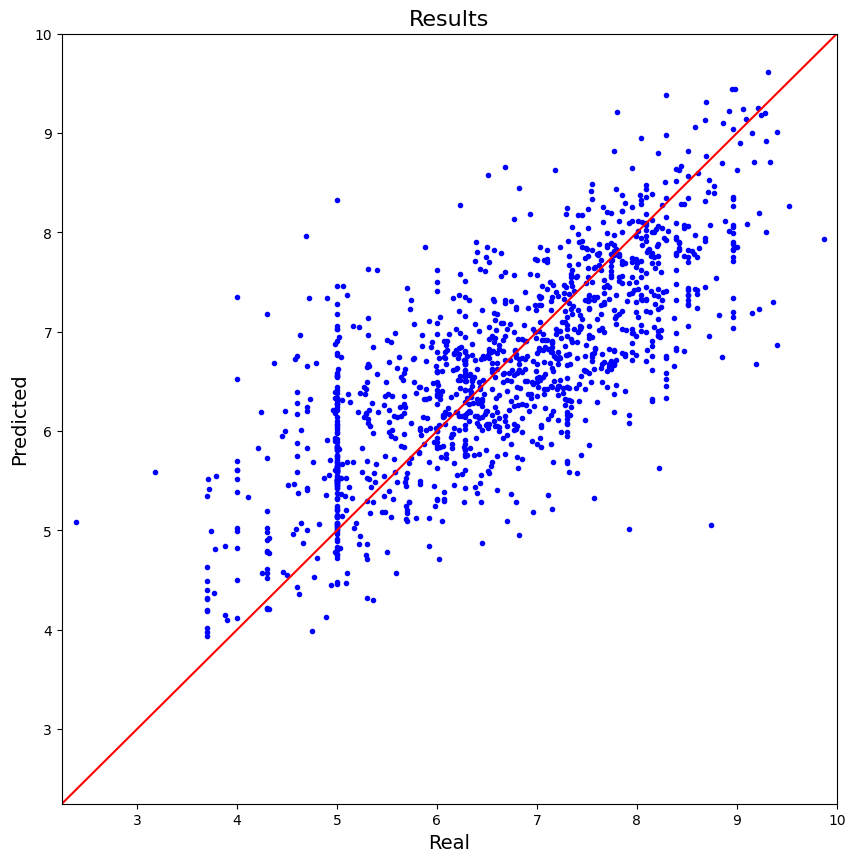

In [48]:
plt.figure(figsize=(10,10))
x=np.linspace(0,10,10)
plt.plot(ytest, y_pred_bayesian_ridge, 'b.')
plt.plot(x, x, 'r-')
plt.xlim(2.25,10)
plt.ylim(2.25,10)
plt.title("Results", fontsize=16)
plt.xlabel("Real", fontsize=14)
plt.ylabel("Predicted", fontsize=14)
plt.savefig("Results.png")
plt.show()

Try with reduction dimensionality

In [90]:
# Import the 3 dimensionality reduction methods
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [86]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
X = xtrain.values
X_std = StandardScaler().fit_transform(X)

In [87]:
# Calculating Eigenvectors and eigenvalues of Cov matirx
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Create a list of (eigenvalue, eigenvector) tuples
eig_pairs = [ (np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the eigenvalue, eigenvector pair from high to low
eig_pairs.sort(key = lambda x: x[0], reverse= True)

# Calculation of Explained Variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

In [88]:
# Find the eigenvector beyond which 90% of the data is explained
[ n for n,i in enumerate(cum_var_exp) if i>90 ][0]

711

In [92]:
# Call the PCA method with 711 components. 
pca = PCA(n_components=711)
pca.fit(X_std)
X_711d = pca.transform(X_std)
print(X_711d.shape)

(3080, 711)


In [99]:
rf_grid_search_2 = GridSearchCV(estimator=RandomForestRegressor(),
                              param_grid=rf_params_2, cv=5)
rf_grid_search_2.fit(X_711d, ytrain)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None], 'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 10],
                         'n_estimators': [200, 300], 'n_jobs': [-1]})

In [104]:
rf_grid_search_2.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'n_jobs': -1}

In [108]:
# Random Forest Grid Search 2
y_pred_rf_gs = rf_grid_search_2.predict(test_711d)
print("\nRandom Forest Grid Search Performance:")
print("mae:", mean_absolute_error(ytest, y_pred_rf_gs))


Random Forest Grid Search Performance:
mae: 0.7399917946990363


In [94]:

# Use 25 decision trees in our random forest and initialize
clf = RandomForestRegressor(n_jobs=-1)

# Train the classifier
clf = clf.fit(X_711d,ytrain)

In [95]:
test_values = xtest.values
test_std = StandardScaler().fit_transform(test_values)
test_711d = pca.transform(test_std)

output_predictions = clf.predict(test_711d)

In [98]:
mae_linear = median_absolute_error(ytest, output_predictions)
print(f"Mean Absolute Error (Linear Regression): {mae_linear:.4f}")

Mean Absolute Error (Linear Regression): 0.6365


We can now predict X_test and make a submission file (csv) that will later be uploaded on the challenge's website. 

In [19]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [11]:
submission_df = pd.DataFrame()
submission_df['id'] = test['id']
submission_df['y'] = y_pred

#submission_df.to_csv('../data/y_benchmark.csv', index=False)